In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"
from tqdm import tqdm
import gc
import os

Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indcies_Array = np.array(
    [117251, 300903, 324123, 329508, 382215, 400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


In [2]:
Subhalo_Fields=['SubhaloMassType','SubhaloVmax','SubhaloStarMetallicity']
PartType4_Fields=['GFM_Metallicity','GFM_StellarFormationTime']


In [3]:
for Subhalo_Index in Lbsg_Indcies_Array:
    Current_Snapshot=99
    Subhalo_Dict=il.groupcat.loadSingle(basePath,Current_Snapshot,-1,Subhalo_Index)
    for Field in Subhalo_Fields:
        globals()[Field]=Subhalo_Dict[Field]

    print(SubhaloVmax)


467.4908
425.86893
407.57916
546.8519
398.1684
397.8141
311.3193
312.40555
155.51685
261.4075


In [4]:
Subhalos_Dict=il.groupcat.loadSubhalos(basePath,99,fields=Subhalo_Fields)
condition=(Subhalos_Dict['SubhaloMassType'][:,4]>0.1)
Galaxies_Indices=np.where(condition)[0]


(array([0.00000000e+00, 0.00000000e+00, 1.08435270e-03, 1.19425331e-02,
        9.39283894e-03, 5.14334862e-03, 3.16513761e-03, 2.09543833e-03,
        1.39207441e-03, 1.18692661e-03, 7.76630989e-04, 4.54255861e-04,
        3.95642202e-04, 3.37028542e-04, 1.75840979e-04, 2.34454638e-04,
        2.19801223e-04, 4.39602446e-05, 1.17227319e-04, 4.39602446e-05,
        7.32670744e-05, 2.93068298e-05, 2.93068298e-05]),
 array([  0.        ,  26.08695652,  52.17391304,  78.26086957,
        104.34782609, 130.43478261, 156.52173913, 182.60869565,
        208.69565217, 234.7826087 , 260.86956522, 286.95652174,
        313.04347826, 339.13043478, 365.2173913 , 391.30434783,
        417.39130435, 443.47826087, 469.56521739, 495.65217391,
        521.73913043, 547.82608696, 573.91304348, 600.        ]),
 <BarContainer object of 23 artists>)

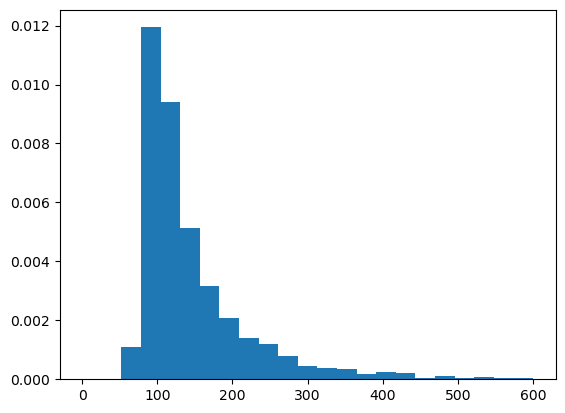

In [9]:
bins=np.linspace(0,600,24)
plt.hist(Subhalos_Dict['SubhaloVmax'][Galaxies_Indices],bins,density=1)
